In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow.compat.v1 as tf

# Helper libraries
import struct
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


In [26]:
# helper function

def read_data(image_path, label_path):
    with open(image_path,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        print("label size: ", size)
        
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, nrows*ncols))
        
    with open(label_path, 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        print("label size: ", size)
        labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    
    return data, labels

In [27]:
image_path = "train-images-idx3-ubyte"
label_path = "train-labels-idx1-ubyte"
images, labels = read_data(image_path, label_path)
print(images.shape, labels.shape)

label size:  60000
label size:  60000
(60000, 784) (60000,)


[5]


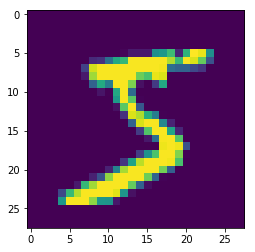

In [8]:
# test 
print(labels[0])
plt.imshow(images[0,:,:])

In [102]:
#"random" in "random_hi"
#"random" in "r_hi"

True

In [121]:
# build determined W first 
class MnistClassification():
    def __init__(self, input_size, hidden_size, learning_rate, net_struct, forward_only=True):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.net_struct = net_struct
        self.forward_only = forward_only
        self.print_ops = []
        self.global_step = tf.Variable(0, trainable=False)
        
        # build
        self._build_placeholder()
        self._build_graph_and_get_loss()
        
        self.saver = tf.train.Saver(tf.global_variables())
        
    def _build_placeholder(self):
        self.images = tf.placeholder(dtype=tf.float32, shape=(None, self.input_size), name="images")
        self.labels = tf.placeholder(dtype=tf.int32, shape=(None), name="labels")
        if "random" in self.net_struct:
            self.random_1 = tf.placeholder(dtype=tf.float32, shape=(self.input_size, self.hidden_size), name='r1')
            self.random_2 = tf.placeholder(dtype=tf.float32, shape=(self.hidden_size, self.hidden_size), name='r2')
            self.random_3 = tf.placeholder(dtype=tf.float32, shape=(self.hidden_size, 10), name='r3')
            
    def _build_graph_and_get_loss(self):
        # get variables
        if "random" not in self.net_struct:
            self.W1 = tf.Variable(tf.random_normal([self.input_size, self.hidden_size], stddev=0.35), name="W1")
            self.W2 = tf.Variable(tf.random_normal([self.hidden_size, self.hidden_size], stddev=0.35), name="W2")
            self.W3 = tf.Variable(tf.random_normal([self.hidden_size, 10], stddev=0.35), name="W3")
        else:
            self.mu_1 = tf.Variable(tf.random_normal([self.input_size, self.hidden_size], stddev=0.35), name="mu1")
            self.rho_1 = tf.Variable(tf.random_normal([self.input_size, self.hidden_size], stddev=0.35), name="rho1")
            
            self.mu_2 = tf.Variable(tf.random_normal([self.hidden_size, self.hidden_size], stddev=0.35), name="mu_2")
            self.rho_2 = tf.Variable(tf.random_normal([self.hidden_size, self.hidden_size], stddev=0.35), name="rho_2")
            
            self.mu_3 = tf.Variable(tf.random_normal([self.hidden_size, 10], stddev=0.35), name="mu_3")
            self.rho_3 = tf.Variable(tf.random_normal([self.hidden_size, 10], stddev=0.35), name="rho_3")
            
            # build graph
            self.W1 = self.mu_1 + self.random_1 * tf.math.sqrt(tf.math.log(1 + tf.math.exp(self.rho_1)))
            self.W2 = self.mu_2 + self.random_2 * tf.math.sqrt(tf.math.log(1 + tf.math.exp(self.rho_2)))
            self.W3 = self.mu_3 + self.random_3 * tf.math.sqrt(tf.math.log(1 + tf.math.exp(self.rho_3)))
            
        self.tmp = None
        self.y = None 
        # build graph 
        self.tmp = tf.matmul(self.images, self.W1)
        self.tmp = tf.nn.relu(self.tmp, name="relu1")

        self.tmp = tf.matmul(self.tmp, self.W2)
        self.tmp = tf.nn.relu(self.tmp, name="relu2")

        self.y = tf.matmul(self.tmp, self.W3)
        self.y = tf.nn.softmax(self.y, axis=1) + 1e-7
        
        # create one hot encoding for labels
        self.one_hot_labels = tf.one_hot(self.labels, depth=10)
        #self.print_ops.append(tf.print("labels: ", self.labels, tf.shape(self.labels)))
        #self.print_ops.append(tf.print("One hot labels: ", self.one_hot_labels, tf.shape(self.one_hot_labels)))
        
        # compute loss
        self.loss = tf.reduce_sum(-tf.math.log(self.y) * self.one_hot_labels)
        #self.print_ops.append(tf.print("mask: ", -tf.math.log(self.y) * self.one_hot_labels))
        #self.print_ops.append(tf.print("the step loss: ", self.loss))
        
        # check whether the model can overfit the train batch
        self.preds = tf.cast(tf.argmax(self.y, axis=1), dtype=tf.int32)
        self.accu = tf.reduce_sum(tf.cast(tf.equal(self.preds, self.labels), dtype=tf.float32)) / \
                                    tf.cast(tf.shape(self.preds)[0], tf.float32)
        #self.print_ops.append(tf.print("preds: ", self.preds, tf.shape(self.preds)))
        #self.print_ops.append(tf.print("labels: ", self.labels, tf.shape(self.labels)))
        
        if not self.forward_only:
            # apply gradients 
            self.update = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss,global_step=self.global_step)
        else:
            pass
            
        
        
    def step(self, session, input_feed, forward_only):
        if not forward_only:
            output_feed = [self.loss, self.accu, self.update, self.print_ops]
        else:
            output_feed = [self.accu]
        
        outputs = session.run(output_feed, input_feed)
        
        if not forward_only:
            return outputs[0], outputs[1]
        else:
            return outputs[0]
        

class Dataset():
    def __init__(self, model, image_path, label_path, batch_size):
        self.model = model
        self.image_path = image_path
        self.label_path = label_path
        self.images, self.labels = self._read_images_and_labels()
        self.images = self.images / 126.0
        self.batch_size = batch_size
        
    def _read_images_and_labels(self):
        with open(self.image_path,'rb') as f:
            magic, size = struct.unpack(">II", f.read(8))
            nrows, ncols = struct.unpack(">II", f.read(8))
            print("label size: ", size)

            data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
            data = data.reshape((size, nrows*ncols))

        with open(self.label_path, 'rb') as f:
            magic, size = struct.unpack(">II", f.read(8))
            print("label size: ", size)
            labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        
        return data, labels
    
    def initilize_epoch(self):
        self.cur_idx = 0
        pertumation_idxs = np.random.permutation(self.images.shape[0])
        self.images = self.images[pertumation_idxs, :]
        self.labels = self.labels[pertumation_idxs]
        
    def get_train_batch(self):
        input_feed = {}
        
        if self.cur_idx + self.batch_size > self.images.shape[0]:
            has_next = False
            input_feed[self.model.images.name] = self.images[self.cur_idx: self.images.shape[0]]
            input_feed[self.model.labels.name] = self.labels[self.cur_idx: self.images.shape[0]]
            
            if "random" in self.model.net_struct:
                input_feed[self.model.random_1.name] = np.random.normal(size=(self.model.input_size, self.model.hidden_size))
                input_feed[self.model.random_2.name] = np.random.normal(size=(self.model.hidden_size, self.model.hidden_size)) 
                input_feed[self.model.random_3.name] = np.random.normal(size=(self.model.hidden_size, 10)) 
    
            return input_feed, has_next
        else:
            has_next = True
            input_feed[self.model.images.name] = self.images[self.cur_idx: self.cur_idx+self.batch_size]
            input_feed[self.model.labels.name] = self.labels[self.cur_idx: self.cur_idx+self.batch_size]
            
            if "random" in self.model.net_struct:
                input_feed[self.model.random_1.name] = np.random.normal(size=(self.model.input_size, self.model.hidden_size))
                input_feed[self.model.random_2.name] = np.random.normal(size=(self.model.hidden_size, self.model.hidden_size)) 
                input_feed[self.model.random_3.name] = np.random.normal(size=(self.model.hidden_size, 10)) 
                
            self.cur_idx += self.batch_size
            return input_feed, has_next
        
    
    def get_test_batch(self):
        input_feed = {}
            
        input_feed[self.model.images.name] = self.images[0: self.images.shape[0]]
        input_feed[self.model.labels.name] = self.labels[0: self.images.shape[0]]
        
        if "random" in self.model.net_struct:
            input_feed[self.model.random_1.name] = np.random.normal(size=(self.model.input_size, self.model.hidden_size))
            input_feed[self.model.random_2.name] = np.random.normal(size=(self.model.hidden_size, self.model.hidden_size)) 
            input_feed[self.model.random_3.name] = np.random.normal(size=(self.model.hidden_size, 10)) 
            
        return input_feed
        
def train():
    # place for all hyperparamters and settings
    image_path = "train-images-idx3-ubyte"
    label_path = "train-labels-idx1-ubyte"
    ckpt_file = ""
    epochs = 500
    learning_rate = 1e-3
    batch_size = 100
    input_size = 28*28
    hidden_size = 200
    
    
    
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    
    with tf.Session(config=config) as sess:
        model = MnistClassification(input_size, hidden_size, learning_rate, net_struct="random_factor", forward_only=False)
        dataset = Dataset(model, image_path, label_path, batch_size)
        init_op = tf.initialize_all_variables()
        sess.run(init_op)
        for i in range(epochs):
            print("In epoch: ", i)
            has_next = True
            idx = 0
            
            dataset.initilize_epoch()
            while has_next:
                idx+=1

                input_feed, has_next = dataset.get_train_batch()
                #print(input_feed.keys())

                loss, accu = model.step(sess, input_feed, forward_only=False)
                
                if idx % 10 == 0:
                    print("loss: %.3f\t accuracy: %.3f "%(loss/batch_size, accu))
        
        #ckpt_path = "./" + "mnist_det_weight.ckpt"
        #model.saver.save(sess, ckpt_path, global_step=model.global_step)
                
    
        # test file
        image_path = "t10k-images-idx3-ubyte"
        label_path = "t10k-labels-idx1-ubyte"
        dataset = Dataset(model, image_path, label_path, batch_size)
        input_feed = dataset.get_test_batch()
        accu = model.step(sess, input_feed, forward_only=True)
        print("accuracy: ", accu)
        

In [122]:
train()
#test()

label size:  60000
label size:  60000
In epoch:  0
loss: 15.099	 accuracy: 0.060 
loss: 14.829	 accuracy: 0.080 
loss: 14.829	 accuracy: 0.080 
loss: 14.667	 accuracy: 0.090 
loss: 14.345	 accuracy: 0.110 
loss: 14.259	 accuracy: 0.110 
loss: 14.829	 accuracy: 0.080 
loss: 15.312	 accuracy: 0.050 
loss: 15.312	 accuracy: 0.050 
loss: 13.701	 accuracy: 0.150 
loss: 14.345	 accuracy: 0.110 
loss: 14.829	 accuracy: 0.080 
loss: 12.894	 accuracy: 0.200 
loss: 14.506	 accuracy: 0.100 
loss: 14.023	 accuracy: 0.130 
loss: 14.667	 accuracy: 0.090 
loss: 14.990	 accuracy: 0.070 
loss: 14.021	 accuracy: 0.130 
loss: 14.187	 accuracy: 0.120 
loss: 14.829	 accuracy: 0.080 
loss: 14.829	 accuracy: 0.080 
loss: 13.862	 accuracy: 0.140 
loss: 15.312	 accuracy: 0.050 
loss: 13.056	 accuracy: 0.190 
loss: 15.151	 accuracy: 0.060 
loss: 14.667	 accuracy: 0.090 
loss: 14.506	 accuracy: 0.100 
loss: 14.506	 accuracy: 0.100 
loss: 14.636	 accuracy: 0.090 
loss: 13.378	 accuracy: 0.170 
loss: 14.171	 accur

loss: 14.023	 accuracy: 0.130 
loss: 13.557	 accuracy: 0.150 
loss: 14.143	 accuracy: 0.120 
loss: 14.990	 accuracy: 0.070 
loss: 14.023	 accuracy: 0.130 
loss: 15.275	 accuracy: 0.050 
loss: 15.473	 accuracy: 0.040 
loss: 13.862	 accuracy: 0.140 
loss: 14.829	 accuracy: 0.080 
loss: 14.345	 accuracy: 0.110 
loss: 15.473	 accuracy: 0.040 
loss: 14.829	 accuracy: 0.080 
loss: 13.539	 accuracy: 0.160 
loss: 14.990	 accuracy: 0.070 
loss: 13.862	 accuracy: 0.140 
loss: 14.667	 accuracy: 0.090 
loss: 15.473	 accuracy: 0.040 
loss: 12.733	 accuracy: 0.210 
loss: 14.829	 accuracy: 0.080 
loss: 14.667	 accuracy: 0.090 
loss: 14.663	 accuracy: 0.090 
loss: 14.296	 accuracy: 0.100 
loss: 14.829	 accuracy: 0.080 
loss: 14.023	 accuracy: 0.130 
loss: 14.184	 accuracy: 0.120 
loss: 13.862	 accuracy: 0.140 
loss: 13.378	 accuracy: 0.170 
loss: 13.697	 accuracy: 0.150 
loss: 13.700	 accuracy: 0.150 
loss: 15.151	 accuracy: 0.060 
loss: 13.700	 accuracy: 0.150 
loss: 13.700	 accuracy: 0.150 
loss: 15

loss: 11.444	 accuracy: 0.290 
loss: 14.023	 accuracy: 0.130 
loss: 13.378	 accuracy: 0.170 
loss: 13.056	 accuracy: 0.190 
loss: 12.432	 accuracy: 0.220 
loss: 14.555	 accuracy: 0.090 
loss: 13.539	 accuracy: 0.160 
loss: 13.217	 accuracy: 0.180 
loss: 13.217	 accuracy: 0.180 
loss: 14.184	 accuracy: 0.120 
loss: 14.993	 accuracy: 0.070 
loss: 13.862	 accuracy: 0.140 
loss: 13.862	 accuracy: 0.140 
loss: 12.894	 accuracy: 0.200 
loss: 14.023	 accuracy: 0.130 
loss: 11.283	 accuracy: 0.300 
In epoch:  9
loss: 14.506	 accuracy: 0.100 
loss: 13.539	 accuracy: 0.160 
loss: 13.056	 accuracy: 0.190 
loss: 13.862	 accuracy: 0.140 
loss: 13.217	 accuracy: 0.180 
loss: 14.181	 accuracy: 0.120 
loss: 14.506	 accuracy: 0.100 
loss: 13.378	 accuracy: 0.170 
loss: 15.151	 accuracy: 0.060 
loss: 12.733	 accuracy: 0.210 
loss: 13.217	 accuracy: 0.180 
loss: 14.184	 accuracy: 0.120 
loss: 14.667	 accuracy: 0.090 
loss: 13.217	 accuracy: 0.180 
loss: 13.378	 accuracy: 0.170 
loss: 12.572	 accuracy: 0.

loss: 14.990	 accuracy: 0.070 
loss: 13.378	 accuracy: 0.170 
loss: 13.056	 accuracy: 0.190 
loss: 12.733	 accuracy: 0.210 
loss: 12.895	 accuracy: 0.200 
loss: 13.378	 accuracy: 0.170 
loss: 13.056	 accuracy: 0.190 
loss: 12.572	 accuracy: 0.220 
loss: 14.023	 accuracy: 0.130 
loss: 13.378	 accuracy: 0.170 
loss: 12.572	 accuracy: 0.220 
loss: 13.539	 accuracy: 0.160 
loss: 12.635	 accuracy: 0.210 
loss: 13.217	 accuracy: 0.180 
loss: 13.308	 accuracy: 0.170 
loss: 14.829	 accuracy: 0.080 
loss: 13.217	 accuracy: 0.180 
loss: 14.184	 accuracy: 0.120 
loss: 12.411	 accuracy: 0.230 
loss: 12.411	 accuracy: 0.230 
loss: 13.700	 accuracy: 0.150 
loss: 13.378	 accuracy: 0.170 
loss: 13.539	 accuracy: 0.160 
loss: 13.217	 accuracy: 0.180 
loss: 13.700	 accuracy: 0.150 
loss: 12.089	 accuracy: 0.250 
loss: 14.506	 accuracy: 0.100 
loss: 11.605	 accuracy: 0.280 
loss: 13.378	 accuracy: 0.170 
loss: 12.790	 accuracy: 0.200 
loss: 13.701	 accuracy: 0.150 
loss: 11.121	 accuracy: 0.310 
loss: 12

loss: 11.605	 accuracy: 0.280 
loss: 14.184	 accuracy: 0.120 
loss: 12.572	 accuracy: 0.220 
loss: 11.605	 accuracy: 0.280 
loss: 9.925	 accuracy: 0.380 
loss: 10.960	 accuracy: 0.320 
loss: 10.638	 accuracy: 0.340 
loss: 13.056	 accuracy: 0.190 
loss: 12.089	 accuracy: 0.250 
loss: 12.894	 accuracy: 0.200 
loss: 12.312	 accuracy: 0.230 
loss: 11.766	 accuracy: 0.270 
loss: 11.121	 accuracy: 0.310 
loss: 12.894	 accuracy: 0.200 
loss: 11.766	 accuracy: 0.270 
loss: 12.089	 accuracy: 0.250 
loss: 11.281	 accuracy: 0.300 
loss: 12.894	 accuracy: 0.200 
loss: 11.444	 accuracy: 0.290 
loss: 10.154	 accuracy: 0.370 
loss: 11.767	 accuracy: 0.270 
loss: 11.283	 accuracy: 0.300 
loss: 12.410	 accuracy: 0.230 
loss: 10.799	 accuracy: 0.330 
loss: 14.184	 accuracy: 0.120 
loss: 11.283	 accuracy: 0.300 
loss: 12.733	 accuracy: 0.210 
loss: 12.089	 accuracy: 0.250 
loss: 13.217	 accuracy: 0.180 
loss: 12.572	 accuracy: 0.220 
In epoch:  18
loss: 12.733	 accuracy: 0.210 
loss: 12.411	 accuracy: 0.

loss: 11.605	 accuracy: 0.280 
loss: 13.700	 accuracy: 0.150 
loss: 10.477	 accuracy: 0.350 
loss: 11.283	 accuracy: 0.300 
loss: 10.638	 accuracy: 0.340 
loss: 11.927	 accuracy: 0.260 
loss: 11.283	 accuracy: 0.300 
In epoch:  22
loss: 12.089	 accuracy: 0.250 
loss: 13.056	 accuracy: 0.190 
loss: 8.059	 accuracy: 0.500 
loss: 11.766	 accuracy: 0.270 
loss: 11.605	 accuracy: 0.280 
loss: 10.799	 accuracy: 0.330 
loss: 11.766	 accuracy: 0.270 
loss: 11.121	 accuracy: 0.310 
loss: 10.637	 accuracy: 0.340 
loss: 11.121	 accuracy: 0.310 
loss: 10.799	 accuracy: 0.330 
loss: 13.217	 accuracy: 0.180 
loss: 11.605	 accuracy: 0.280 
loss: 11.121	 accuracy: 0.310 
loss: 11.444	 accuracy: 0.290 
loss: 12.089	 accuracy: 0.250 
loss: 10.316	 accuracy: 0.360 
loss: 11.283	 accuracy: 0.300 
loss: 10.637	 accuracy: 0.340 
loss: 11.444	 accuracy: 0.290 
loss: 10.477	 accuracy: 0.350 
loss: 12.411	 accuracy: 0.230 
loss: 11.605	 accuracy: 0.280 
loss: 10.477	 accuracy: 0.350 
loss: 10.316	 accuracy: 0.

loss: 11.283	 accuracy: 0.300 
loss: 10.960	 accuracy: 0.320 
loss: 10.638	 accuracy: 0.340 
loss: 10.960	 accuracy: 0.320 
loss: 9.832	 accuracy: 0.390 
loss: 11.766	 accuracy: 0.270 
loss: 10.638	 accuracy: 0.340 
loss: 10.316	 accuracy: 0.360 
loss: 10.614	 accuracy: 0.340 
loss: 10.316	 accuracy: 0.360 
loss: 9.993	 accuracy: 0.380 
loss: 10.638	 accuracy: 0.340 
loss: 10.960	 accuracy: 0.320 
loss: 11.685	 accuracy: 0.270 
loss: 10.154	 accuracy: 0.370 
loss: 9.671	 accuracy: 0.400 
loss: 9.832	 accuracy: 0.390 
loss: 12.733	 accuracy: 0.210 
loss: 10.638	 accuracy: 0.340 
loss: 10.477	 accuracy: 0.350 
loss: 10.960	 accuracy: 0.320 
loss: 9.832	 accuracy: 0.390 
loss: 10.477	 accuracy: 0.350 
loss: 11.283	 accuracy: 0.300 
loss: 10.638	 accuracy: 0.340 
loss: 10.408	 accuracy: 0.340 
loss: 10.477	 accuracy: 0.350 
loss: 10.477	 accuracy: 0.350 
loss: 11.283	 accuracy: 0.300 
loss: 10.638	 accuracy: 0.340 
loss: 10.799	 accuracy: 0.330 
loss: 10.316	 accuracy: 0.360 
loss: 9.510	 

loss: 10.799	 accuracy: 0.330 
loss: 10.316	 accuracy: 0.360 
loss: 9.993	 accuracy: 0.380 
loss: 10.477	 accuracy: 0.350 
loss: 11.121	 accuracy: 0.310 
loss: 9.832	 accuracy: 0.390 
loss: 10.477	 accuracy: 0.350 
loss: 7.092	 accuracy: 0.560 
loss: 10.960	 accuracy: 0.320 
loss: 8.704	 accuracy: 0.460 
loss: 9.671	 accuracy: 0.400 
loss: 10.799	 accuracy: 0.330 
loss: 11.605	 accuracy: 0.280 
loss: 11.927	 accuracy: 0.260 
loss: 11.931	 accuracy: 0.260 
loss: 10.960	 accuracy: 0.320 
loss: 8.865	 accuracy: 0.450 
loss: 11.766	 accuracy: 0.270 
loss: 8.865	 accuracy: 0.450 
In epoch:  31
loss: 10.799	 accuracy: 0.330 
loss: 9.832	 accuracy: 0.390 
loss: 10.960	 accuracy: 0.320 
loss: 8.704	 accuracy: 0.460 
loss: 10.799	 accuracy: 0.330 
loss: 9.671	 accuracy: 0.400 
loss: 10.638	 accuracy: 0.340 
loss: 10.154	 accuracy: 0.370 
loss: 9.814	 accuracy: 0.390 
loss: 10.638	 accuracy: 0.340 
loss: 12.411	 accuracy: 0.230 
loss: 11.005	 accuracy: 0.310 
loss: 10.477	 accuracy: 0.350 
loss:

KeyboardInterrupt: 

In [116]:
np.random.normal(size=(3,3))

array([[ 1.02610562, -1.01650157,  0.93031428],
       [ 0.77697671, -1.34013198, -0.36582006],
       [ 0.50928287, -0.67959637,  0.87299247]])